### Import Libraries

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from scipy import stats

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)  

# Styling
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

import plotly.io as pio
pio.renderers.default = 'colab'
pio.templates.default = 'ggplot2'
%matplotlib inline

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

### Import & Splitting Data

Firstly, we split the dataset into two parts, dev set and test set. The dev set will be used for EDA, data preprocessing, and model training. While the test set is an unseen data we use for predicting. 

Since the `PRICE` is related to the `SALEDATE`, we will use 85% of the earliest `SALEDATE` as the dev set and remaining 15% for the test to simulate the real world condition, where we have past data to train and predict the future.

In [2]:
raw_data_link = 'https://raw.githubusercontent.com/elvanselvano/purwadhika-final-project/main/dataset/raw_dataset.csv'
df = pd.read_csv(raw_data_link, index_col=0)

We extract the year from the column `SALEDATE` to use only the data from 2015 to 2018. We use this timeframe to get the latest housing prices (3 years) because if we are using old data, it will not represent the real world cases.

In [3]:
df['SALEDATE'] = pd.to_datetime(df['SALEDATE'])
df['SALEYEAR'] = df['SALEDATE'].dt.year
df['SALEYEAR']

0         2003.0
1         2000.0
2         2016.0
3         2006.0
4            NaN
           ...  
158952    2015.0
158953    2013.0
158954    2008.0
158955    2015.0
158956    2002.0
Name: SALEYEAR, Length: 158957, dtype: float64

In [4]:
df_2013_2018 = df[df['SALEYEAR'] >= 2015].reset_index()
df_2013_2018['SALEYEAR'].value_counts()

2017.0    12399
2016.0    10491
2015.0     9578
2018.0     6636
Name: SALEYEAR, dtype: int64

In [13]:
df_date_sorted = df_2013_2018.sort_values(by='SALEDATE')
(df_date_sorted['SALEDATE'].dropna().shape[0])*0.85

33238.4

In [14]:
dev = df_date_sorted.iloc[:33238,:]
dev = dev.sort_index().reset_index(drop=True)
test = df_date_sorted.iloc[33238:,:]
test = test.sort_index().reset_index(drop=True)

In [15]:
from google.colab import files

dev.to_csv('dev_data.csv',index=False)
dev.to_csv('test_data.csv',index=False)

files.download('dev_data.csv')
files.download('test_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Data Exploration
For data exploration, we will only use the dev dataset to avoid snooping bias.

In [16]:
df = dev.copy() # using only dev set for EDA
df.head()

index  BATHRM  HF_BATHRM  ...          Y QUADRANT  SALEYEAR
0      2       3          1  ...  38.914881       NW    2016.0
1     18       3          1  ...  38.914881       NW    2016.0
2     20       3          1  ...  38.911716       NW    2016.0
3     28       3          0  ...  38.911716       NW    2015.0
4     31       3          0  ...  38.911716       NW    2016.0

[5 rows x 50 columns]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33238 entries, 0 to 33237
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               33238 non-null  int64         
 1   BATHRM              33238 non-null  int64         
 2   HF_BATHRM           33238 non-null  int64         
 3   HEAT                33238 non-null  object        
 4   AC                  33238 non-null  object        
 5   NUM_UNITS           19153 non-null  float64       
 6   ROOMS               33238 non-null  int64         
 7   BEDRM               33238 non-null  int64         
 8   AYB                 33189 non-null  float64       
 9   YR_RMDL             19371 non-null  float64       
 10  EYB                 33238 non-null  int64         
 11  STORIES             19128 non-null  float64       
 12  SALEDATE            33238 non-null  datetime64[ns]
 13  PRICE               25869 non-null  float64   

### Encode Data Types
In order to visualize and analyze the data, we need to cast the data type according to the definition of the feature explained in the previous notebook.

In [18]:
df['NUM_UNITS'] = df['NUM_UNITS'].astype(pd.Int64Dtype())
df['KITCHENS'] = df['KITCHENS'].astype(pd.Int64Dtype())
df['USECODE'] = df['USECODE'].astype(pd.Int64Dtype()).astype('category')
df['ZIPCODE'] = df['ZIPCODE'].astype(pd.Int64Dtype()).astype('category')
df['CMPLX_NUM'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
df['CENSUS_TRACT'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
df['SALEDATE'] = pd.to_datetime(df['SALEDATE'])

## 1. Price

### Qualified Price

The `QUALIFIED` feature is internally-used indicator to reflect if a sale is representative of market value according to the office's internal criteria. The label `Q` means Qualified while `U` means Unqualified. The author of the dataset suggest to drop the `U` records because it will affect the performance of the model.

First, we want to compare these value with `ROOMS` to see the distribution.

In [19]:
q = df[df['QUALIFIED']=='Q'] # qualified property
u = df[df['QUALIFIED']=='U'] # unqualified property

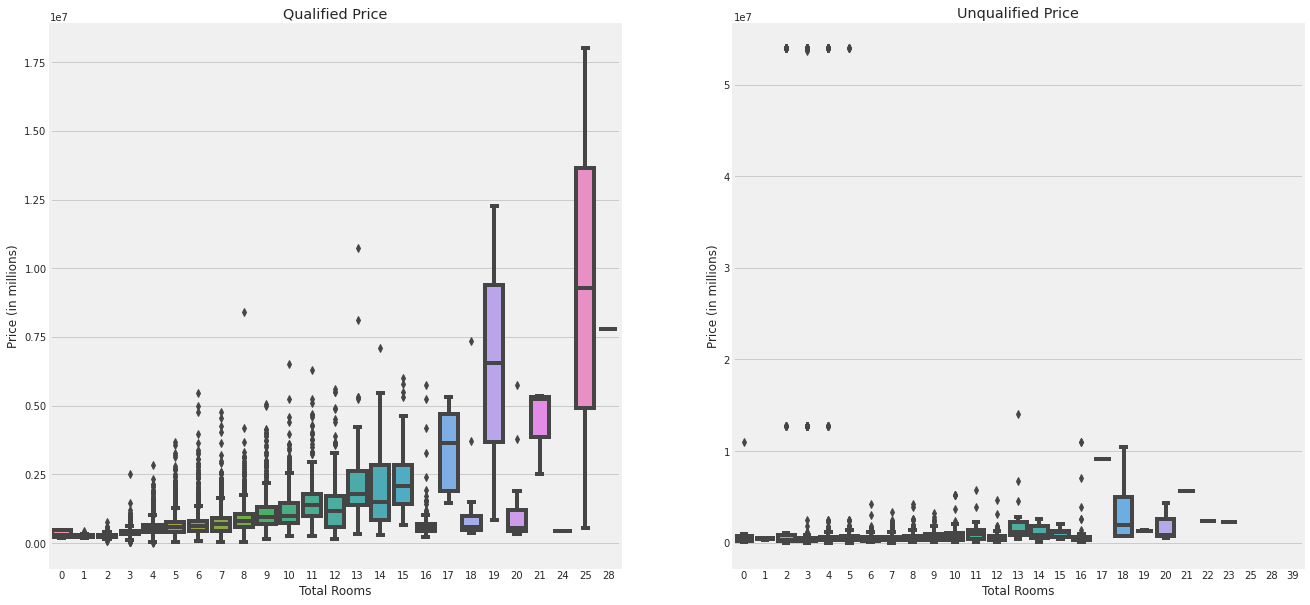

In [20]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
sns.boxplot(x='ROOMS', y='PRICE', data=q, ax=ax[0]).set_title('Qualified Price')
sns.boxplot(x='ROOMS', y='PRICE', data=u, ax=ax[1]).set_title('Unqualified Price')
ax[0].set_ylabel('Price (in millions)')
ax[1].set_ylabel('Price (in millions)')
ax[0].set_xlabel('Total Rooms')
ax[1].set_xlabel('Total Rooms')
plt.show()

Based on the charts above, we can see that the unqualified property does not reflect the market value. Therefore, we will follow the author's suggestion to remove all of the unqualified property from our dataset. Then, we will remove the `QUALIFIED` feature because now it only contains a single value which is `Q`.

In [21]:
df_q = df[df['QUALIFIED']=='Q']
df_q = df_q.drop('QUALIFIED', axis=1)

In [22]:
print('Before removing unqualified property:', df.shape)
print('After removing unqualified property:', df_q.shape)

Before removing unqualified property: (33238, 50)
After removing unqualified property: (20430, 49)


### Price by Year

Now that we have qualified property, we will analyze the price by year. We can see that the price are increasing year by year although there are some years when the price of housing dropped.

In [34]:
df_t = df_q.copy()
df_t['PRICE_MIL'] = df_q['PRICE']/1e6
df_t['SALEYEAR'] = pd.to_datetime(df_t['SALEYEAR'], format='%Y')
yearly_med_price = df_t.groupby('SALEYEAR').median('PRICE_MIL')

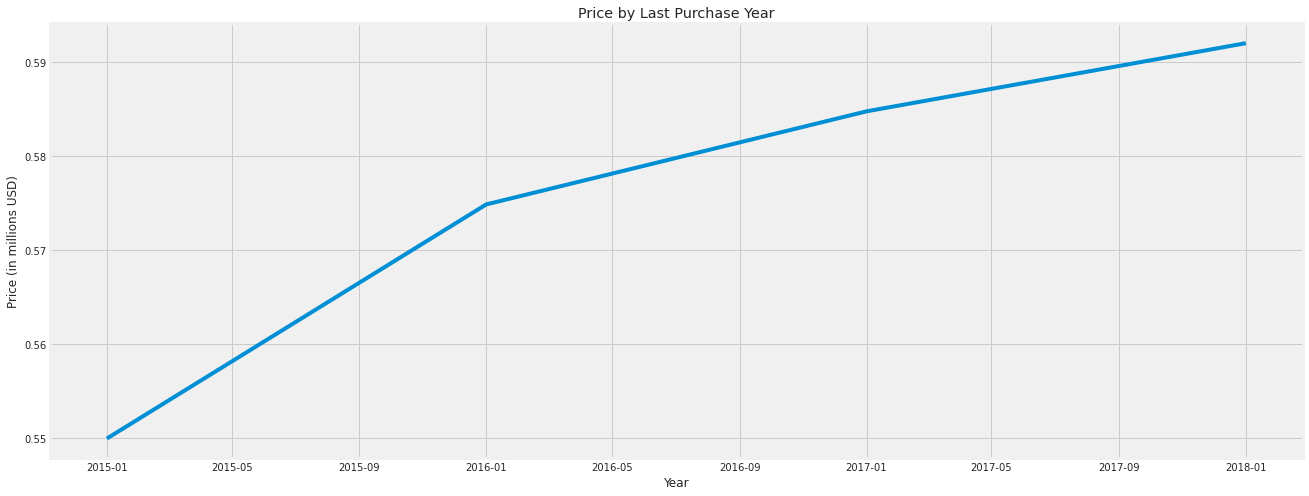

In [36]:
plt.figure(figsize=(20,8))
sns.lineplot(x='SALEYEAR',y='PRICE_MIL',data=yearly_med_price)
plt.title('Price by Last Purchase Year')
plt.xlabel('Year')
plt.ylabel('Price (in millions USD)')
plt.show()

Then, we will split the data based on the `WARD`. We can see that all of the prices are going up even though currently, the price of the property in `WARD 3` is currently downtrend.

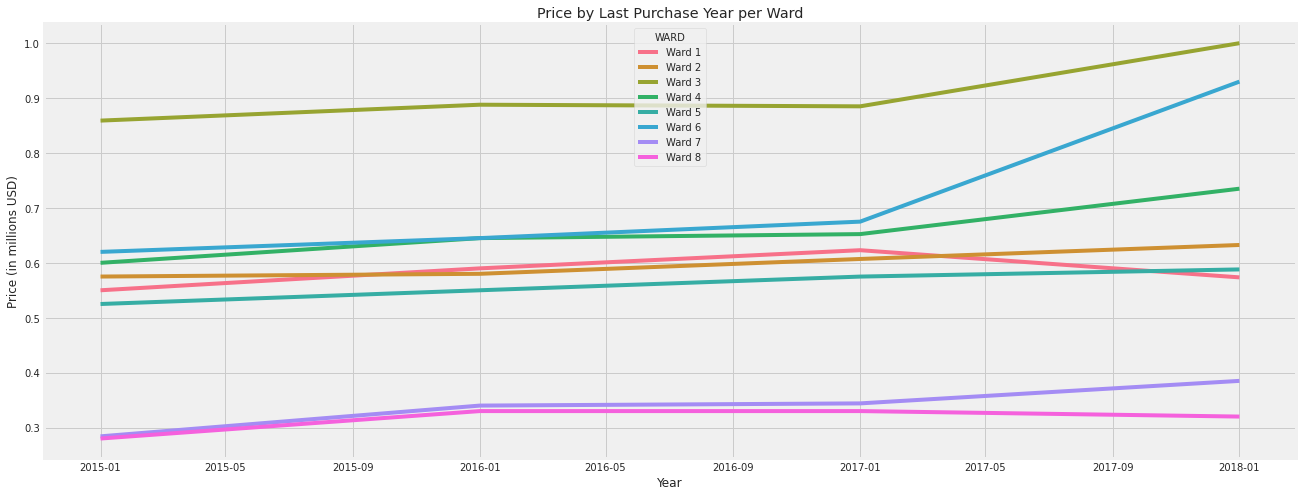

In [37]:
plt.figure(figsize=(20,8))
yearly_ward_price = df_t.groupby(['SALEYEAR','WARD']).median()
sns.lineplot(x='SALEYEAR',y='PRICE_MIL',data=yearly_ward_price , hue='WARD')
plt.title('Price by Last Purchase Year per Ward')
plt.xlabel('Year')
plt.ylabel('Price (in millions USD)')
plt.show()

Now, we will see the distribution of the column `PRICE`. We can see that this column is skewed because there are many houses with very expensive price and some houses with very cheap price.

In [38]:
fig = px.histogram(df_q, x='PRICE', labels = {'PRICE':'Price (USD)'},nbins=200
                   , title='Distribution of Properties Price in DC',
                   color_discrete_sequence=px.colors.sequential.Viridis)

fig.update_layout(showlegend=False, margin=dict(l=20,r=20,t=40,b=20))
fig.show()

For the purpose of data visualization, we will only use **95% data** **(2.5% - 97.5%) in this EDA** in order to gain better insights of the data. It will also help us in finding the patterns in the charts we will be creating.

In [39]:
p2_5 = df_q['PRICE'].quantile(0.025)
p97_5 = df_q['PRICE'].quantile(0.975)

In [40]:
# get 95% data
df_viz_95 = df_q[(df_q['PRICE'] >= p2_5) & (df_q['PRICE'] <= p97_5)]

In [41]:
df_viz_95.PRICE.describe()

count    1.943900e+04
mean     6.482922e+05
std      3.386631e+05
min      2.100000e+05
25%      3.990000e+05
50%      5.700000e+05
75%      8.015000e+05
max      1.950000e+06
Name: PRICE, dtype: float64

After taking 95% of the data, we can see that the distribution is now much better and easier to be analyzed.

In [42]:
fig = px.histogram(df_viz_95, x='PRICE', labels = {'PRICE':'Price (USD)'}, nbins=40
                   ,marginal='box',title='Distribution of Properties Price in DC (95% data)',
                   color_discrete_sequence=px.colors.sequential.Viridis)

fig.update_layout(showlegend=False, margin=dict(l=20,r=20,t=40,b=20))
fig.show()

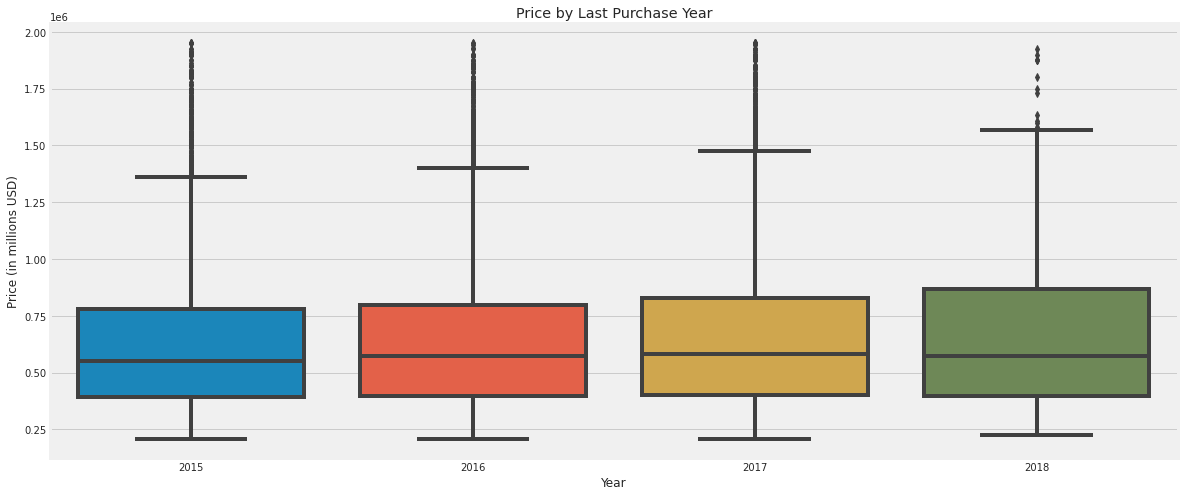

In [43]:
plt.figure(figsize=(18, 8))
sns.boxplot(x=df_viz_95['SALEYEAR'].dropna().astype(int), y=df_viz_95['PRICE'])
plt.title('Price by Last Purchase Year')
plt.xlabel('Year')
plt.ylabel('Price (in millions USD)')
plt.show()

The first chart shows the distribution of the price appears to be right-skewed. The range of the most expensive properties to the median, seems to be far higher than the gap to the lowest. This can reflect to the inequality of DC citizen. We also want to analyze the price distribution between property type and location

## Residential vs Condominium

Despite the difference is very subtle, the residential price is more expensive than the condominium in DC.

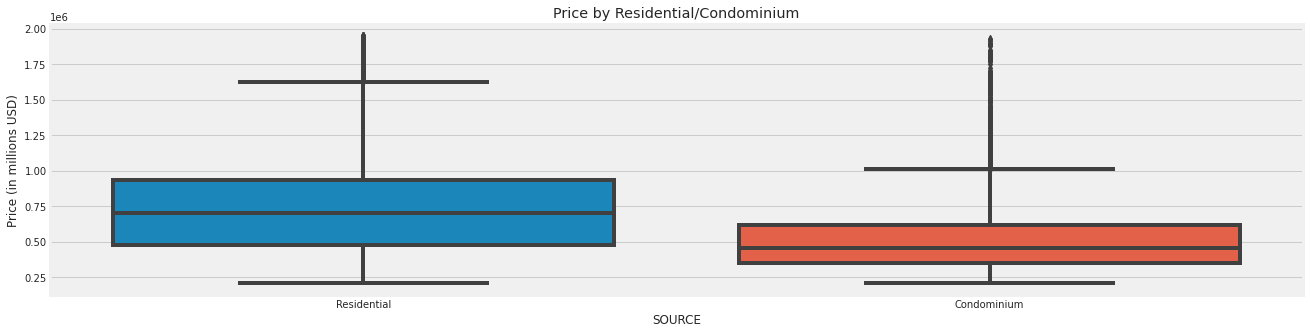

In [44]:
plt.figure(figsize=(20,5))
sns.boxplot(x='SOURCE', y='PRICE', data=df_viz_95).set_title('Price by Residential/Condominium')
plt.ylabel('Price (in millions USD)')
plt.show()

## Location

### Distribution by Region

In [45]:
quadrant = df_viz_95[~df_viz_95['QUADRANT'].isna()]
fig = px.scatter_mapbox(quadrant, lat='LATITUDE', lon='LONGITUDE', color='QUADRANT', hover_data=['QUADRANT', 'PRICE'],
                        color_discrete_sequence=px.colors.qualitative.Vivid, zoom=10, height=400, width=800, opacity=1,
                        title='Distribution of Properties by Quadrant')
fig.update_traces(marker=dict(size=5))
fig.update_layout(mapbox_style='stamen-terrain',margin=dict(l=10,r=0,t=40,b=10))

fig.show()

In [46]:
fig = px.scatter_mapbox(df_viz_95.sort_values(by='WARD'), lat='LATITUDE', lon='LONGITUDE', color='WARD', hover_data=['WARD', 'PRICE'],
                        color_discrete_sequence=px.colors.qualitative.Vivid, zoom=10, height=400, width=800, opacity=1,
                        title='Distribution of Properties by Wards')
fig.update_traces(marker=dict(size=5))
fig.update_layout(mapbox_style='stamen-terrain',margin=dict(l=10,r=0,t=40,b=10))

fig.show()

In [47]:
fig = px.scatter_mapbox(df_viz_95.sort_values(by='ZIPCODE'), lat='LATITUDE', lon='LONGITUDE', color='ZIPCODE', hover_data=['PRICE'],
                        color_discrete_sequence=px.colors.qualitative.Alphabet, zoom=10, height=400, width=800, opacity=1,
                        title='Distribution of Properties by Zipcode')
fig.update_traces(marker=dict(size=5))
fig.update_layout(mapbox_style='stamen-terrain',margin=dict(l=10,r=0,t=40,b=10))

fig.show()

In [48]:
fig = px.scatter_mapbox(df_viz_95, lat='LATITUDE', lon='LONGITUDE', color='ASSESSMENT_NBHD', hover_data=['WARD', 'PRICE'],
                        color_discrete_sequence=px.colors.qualitative.Alphabet, zoom=10, height=400, width=1000, opacity=1,
                        title='Distribution of Properties by Neighborhood')
fig.update_traces(marker=dict(size=5))
fig.update_layout(mapbox_style='stamen-terrain',margin=dict(l=10,r=0,t=40,b=10))
fig.show()

### House Style in Each Region

In [49]:
style = df_viz_95[~df_viz_95['STYLE'].isna()].copy() #remove missing data style
fig = px.scatter_mapbox(style.sort_values(by='STYLE'), lat='LATITUDE', lon='LONGITUDE', color='STYLE', hover_data=['STYLE', 'WARD'],
                        color_discrete_sequence=px.colors.qualitative.Prism, zoom=10, height=400, width=800, opacity=1,
                        title='House Style Mapping')
fig.update_traces(marker=dict(size=3))
fig.update_layout(mapbox_style='stamen-terrain',margin=dict(l=10,r=0,t=40,b=10))
fig.show()

Most of the residential in DC is dominated by 2 Story House. Besides,in the Ward 3 and 4 the number of 2.5 story is quite high, while in the Ward 1 and 6, three story residential is also common.

### Regional Price Distribution

In [50]:
df_viz_95.PRICE.describe()

count    1.943900e+04
mean     6.482922e+05
std      3.386631e+05
min      2.100000e+05
25%      3.990000e+05
50%      5.700000e+05
75%      8.015000e+05
max      1.950000e+06
Name: PRICE, dtype: float64

In [51]:
# grouping price
price_cat_df = df_viz_95.copy()
price_cat_df = price_cat_df.sort_values(by='PRICE')
label = ['<300k','300-600k','600-900k','900k-1.2M','1.2-1.5M','1.5-1.8M','>1.8M']
price_cat_df['PRICE_CAT'] = pd.cut(df_viz_95['PRICE'],bins=(np.arange(0,22,3)*100000).tolist(),labels=label)

In [52]:
fig = px.scatter_mapbox(price_cat_df, lat='LATITUDE', lon='LONGITUDE', color='PRICE_CAT', hover_data=['PRICE', 'WARD'],
                        color_discrete_sequence=px.colors.qualitative.Vivid, zoom=10, height=400, width=800, opacity=0.5,
                        title='Price Mapping')
fig.update_traces(marker=dict(size=3.5))
fig.update_layout(mapbox_style='stamen-terrain',margin=dict(l=10,r=0,t=40,b=10))
fig.show()

The map above indicate the price distribution of residential seems different in each location. We can also see the image from DC government entitled Median Household Income below. It appears the price distribution of properties reflects to the household income. In `Ward 3`, where the properties price is the highest, has also the highest median household income than the others. In contrary, `Ward 7` and `Ward 8`, where the price is the lowest, have the lowest median household income.

We might look into the detail of price distribution in several location features.

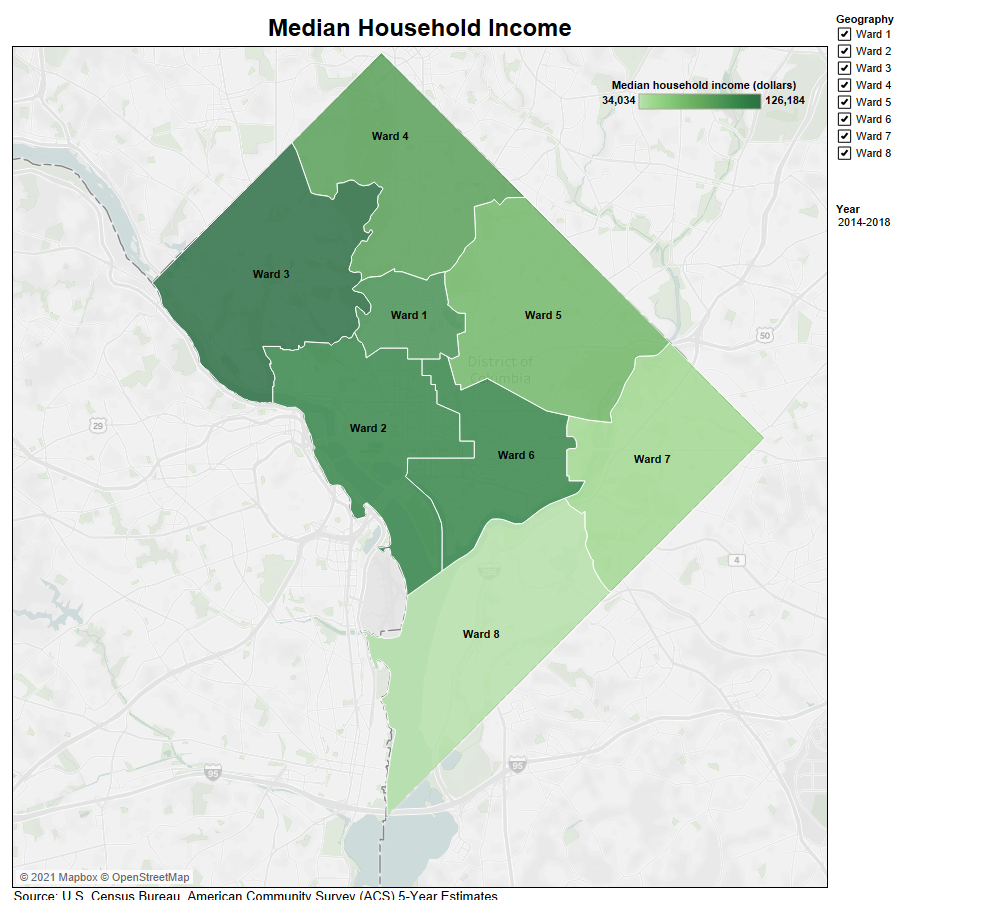

In [53]:
# define function of boxplot vs price_trans
def boxplot_cat_price(df,features,rows,cols,fig_size,title,pad=10,rotation=0,ord=True):
  df_no_na = df[features].copy().dropna()

  fig, ax = plt.subplots(rows,cols,figsize=fig_size)
  for i in range(len(features)-1):
    if ord==True:
      table = df_no_na.groupby([features[i]],as_index=False)['PRICE'].median().sort_values(by='PRICE',ascending=False)
      sns.boxplot(x=features[i],y='PRICE',data=df_no_na,ax=ax[i],order=table[features[i]].to_list()).set_title('Price by '+ features[i],fontsize=17)
    elif ord==False :
      sns.boxplot(x=features[i],y='PRICE',data=df_no_na,ax=ax[i]).set_title('Price by '+ features[i],fontsize=17)
  for i in fig.axes:
    plt.sca(i)
    plt.xticks(rotation=rotation)
    plt.ylabel('Price (in millions USD)')
  fig.suptitle(title, fontsize=25, fontweight='bold')
  fig.tight_layout(pad=pad)
  plt.show()

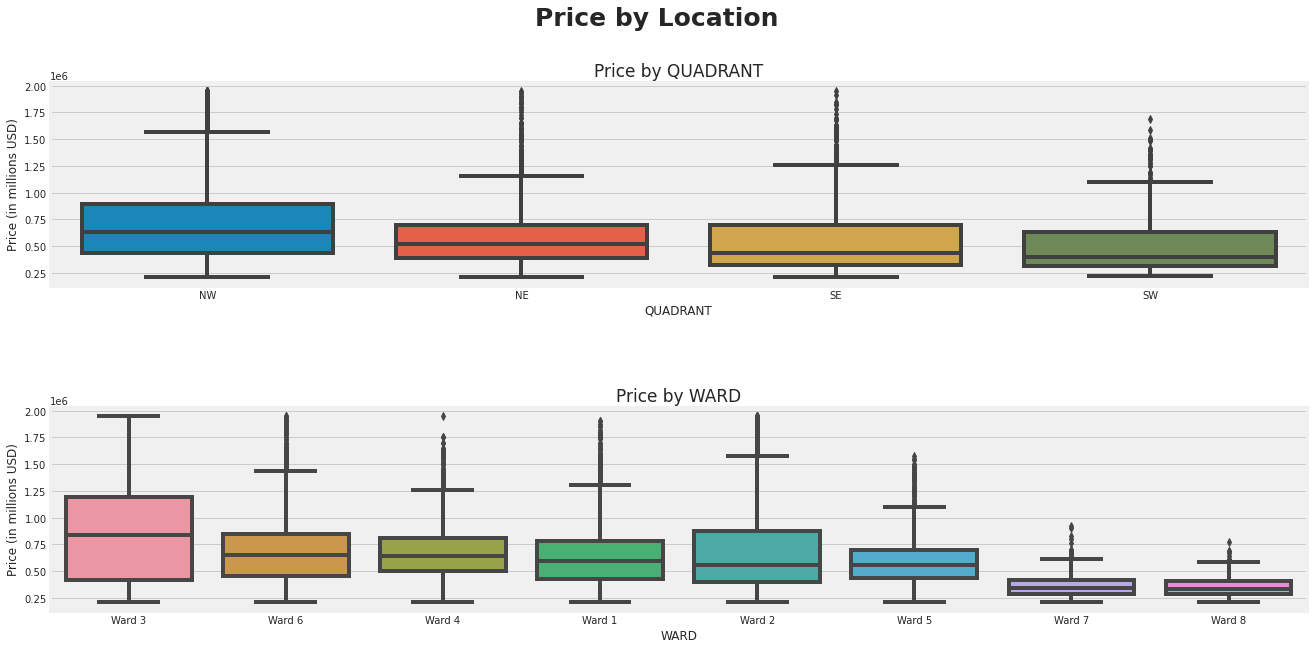

In [54]:
boxplot_cat_price(df=df_viz_95,features=['QUADRANT','WARD','PRICE'],rows=2,cols=1,fig_size=(20,10),title='Price by Location',pad=7)

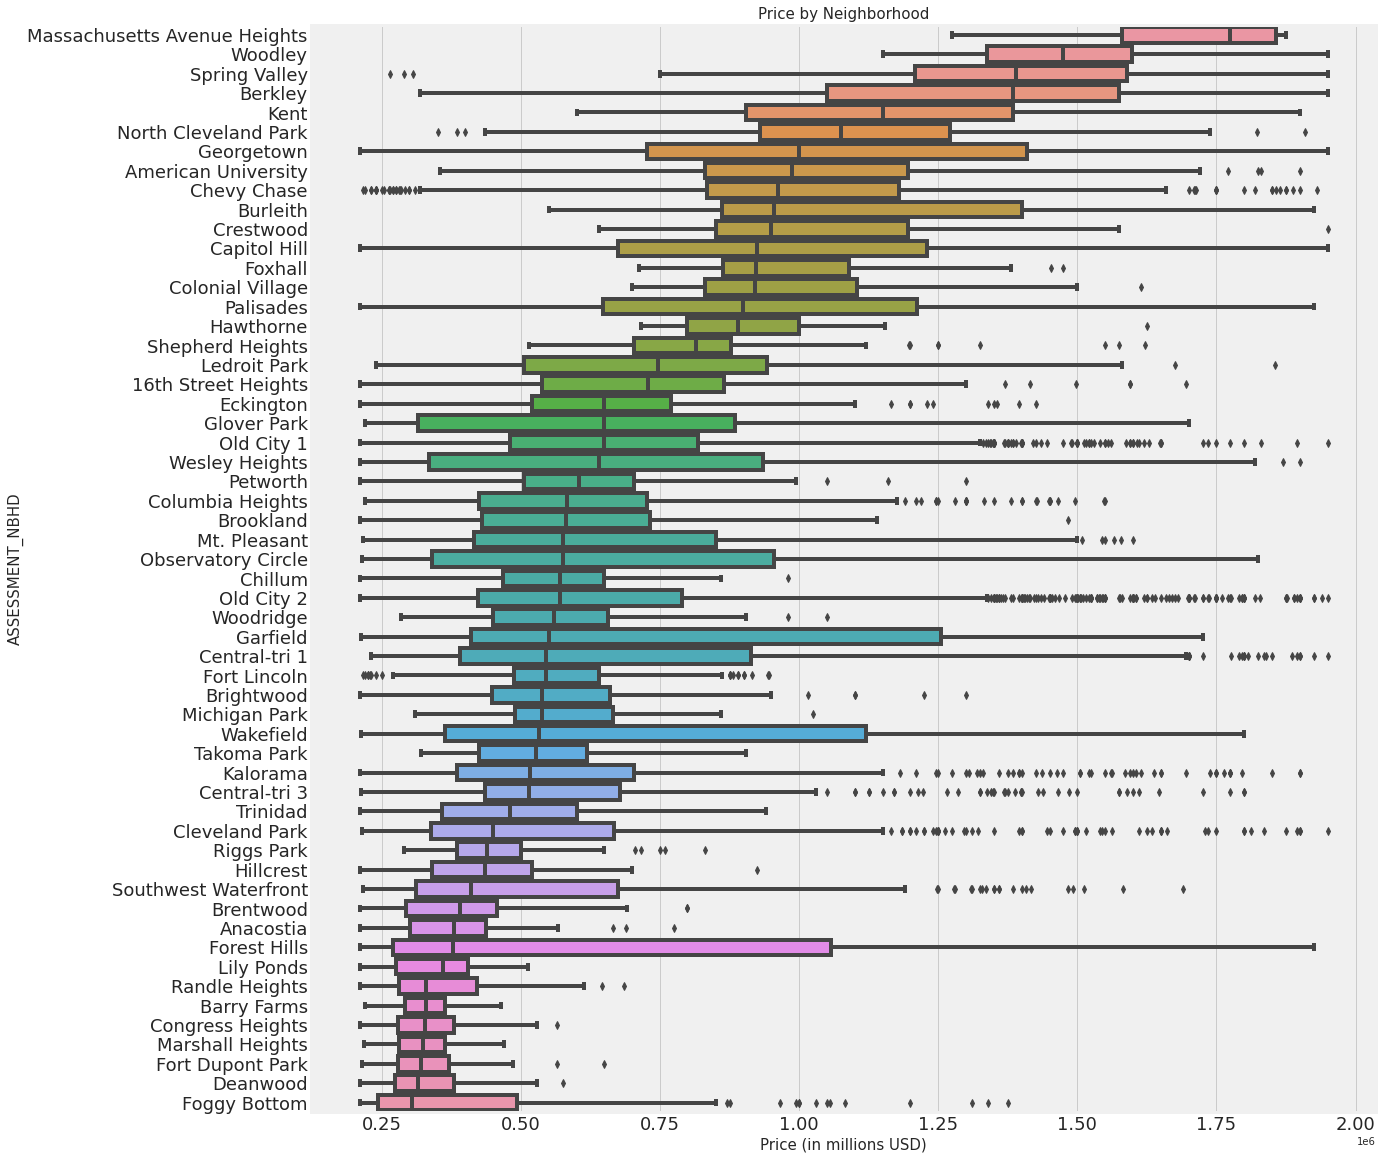

In [55]:
fig=plt.figure(figsize=(17,20))

table = df_viz_95.groupby(['ASSESSMENT_NBHD'],as_index=False)['PRICE'].median().sort_values(by='PRICE',ascending=False)

sns.boxplot(data=df_viz_95,x='PRICE',y='ASSESSMENT_NBHD',order=table['ASSESSMENT_NBHD'].to_list());
plt.yticks(fontsize=18);
plt.xticks(fontsize=18);
plt.title('Price by Neighborhood',fontsize=15)
plt.ylabel("ASSESSMENT_NBHD",fontsize=15);
plt.xlabel('Price (in millions USD)',fontsize=15);

In [56]:
# since the distribution is not normal, we will use the non-parametric test instead
# define function kruskal-wallis test vs price for all categorical value in each feature
def kruskal_price(feature,df):
  group_df = df[[feature, 'PRICE']].dropna().groupby([feature])
  group_list =[]
  val = df[feature].dropna().unique()
  for i in val:
    group_list.append(group_df.get_group(i)['PRICE'])
  
  h_stat, p_val = stats.kruskal(*group_list)
  print('Kruskal-Wallis Test results of {}\nH Stat = {}\nP = {}'.format(feature,h_stat, p_val))

In [57]:
for i in ['QUADRANT','WARD','ASSESSMENT_NBHD']:
  kruskal_price(i,df_q)
  print()

Kruskal-Wallis Test results of QUADRANT
H Stat = 1438.3032587996881
P = 1.4374165090774e-311

Kruskal-Wallis Test results of WARD
H Stat = 3855.184197959833
P = 0.0

Kruskal-Wallis Test results of ASSESSMENT_NBHD
H Stat = 6688.724143098378
P = 0.0



Since all the P-Value is below the alpha 0.05, we reject H0 which means the the population distribution for each features vs price are different. This shows all three features (`Quadrant`,`Ward`, and `Assessment_NBHD`) can distinguish price value.

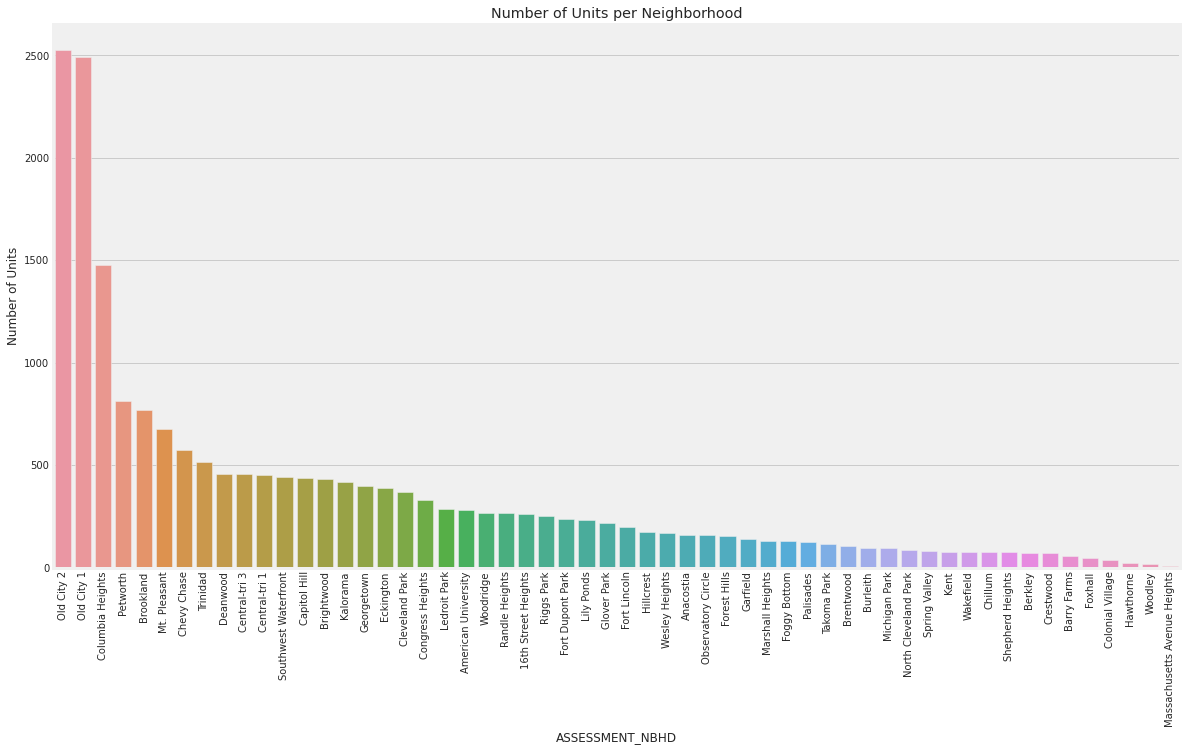

In [58]:
plt.figure(figsize=(18,10))
ca_count=sns.countplot(x=df_viz_95['ASSESSMENT_NBHD'], order = df_viz_95['ASSESSMENT_NBHD'].value_counts().index)
ca_count.set_xticklabels(ca_count.get_xticklabels(),rotation=90)
plt.title('Number of Units per Neighborhood')
plt.ylabel('Number of Units')
plt.show()

## Area

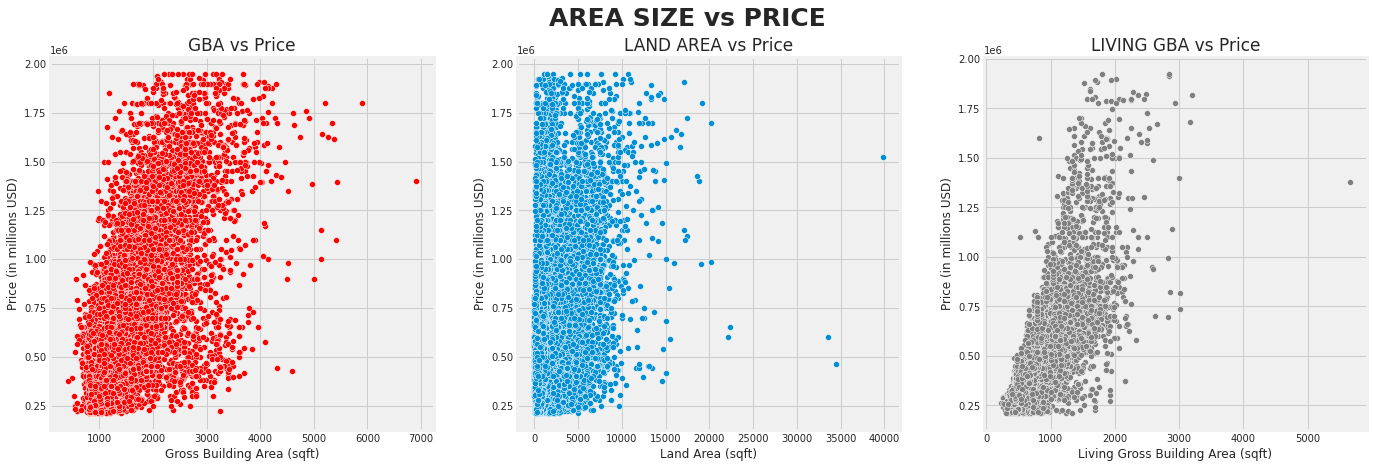

In [59]:
fig, ax =plt.subplots(1,3,figsize=(20,7))
sns.scatterplot(x='GBA',y='PRICE',data=df_viz_95,ax=ax[0],color='r').set_title('GBA vs Price', fontsize=17)
sns.scatterplot(x='LANDAREA',y='PRICE',data=df_viz_95,ax=ax[1]).set_title('LAND AREA vs Price', fontsize=17)
sns.scatterplot(x='LIVING_GBA',y='PRICE',data=df_viz_95,ax=ax[2],color='grey').set_title('LIVING GBA vs Price', fontsize=17)
ax[0].set_xlabel('Gross Building Area (sqft)')
ax[1].set_xlabel('Land Area (sqft)')
ax[2].set_xlabel('Living Gross Building Area (sqft)')
ax[0].set_ylabel('Price (in millions USD)')
ax[1].set_ylabel('Price (in millions USD)')
ax[2].set_ylabel('Price (in millions USD)')
fig.suptitle('AREA SIZE vs PRICE', fontsize=25, fontweight='bold')
fig.tight_layout(pad=4)
plt.show()

## Properties Feature

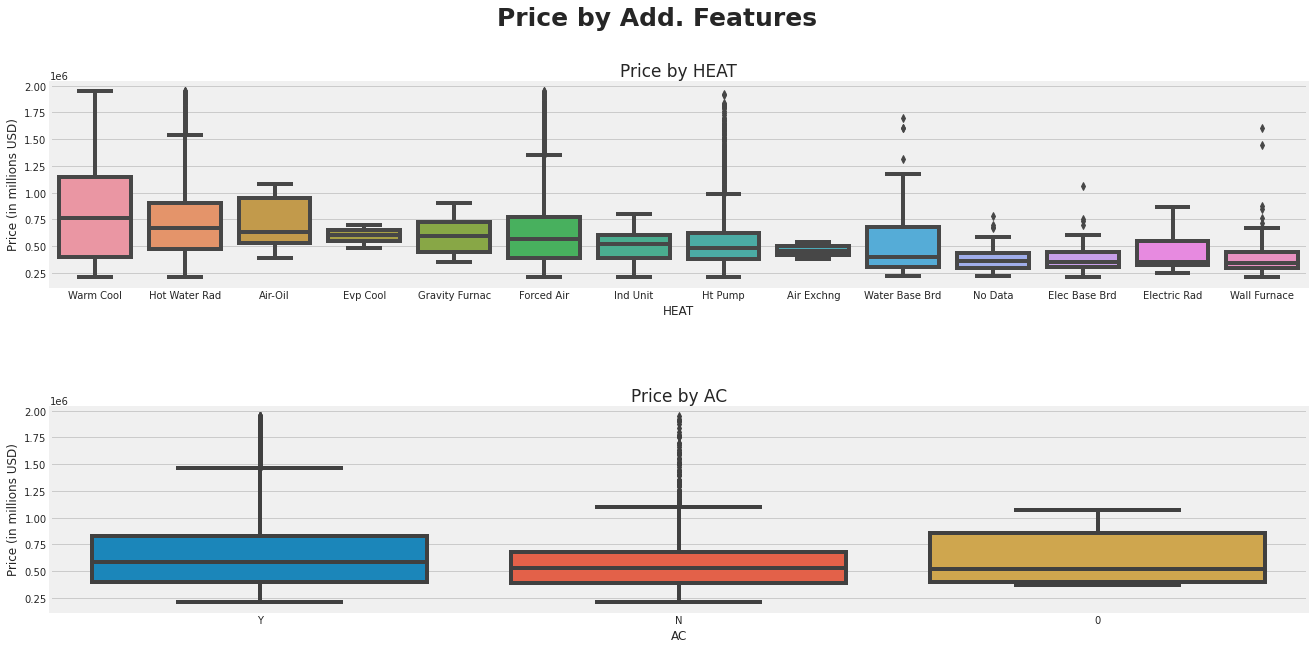

In [60]:
boxplot_cat_price(df=df_viz_95,features=['HEAT','AC','PRICE'],rows=2,cols=1,fig_size=(20,10),title='Price by Add. Features',pad=7)

in `AC`, the `0` value seems to be an `N`. We might encode it first to get better visualization

In [61]:
add_feat = df_viz_95.copy()
add_feat['AC'] = np.where(df_viz_95['AC']=='Y',1,0) #change to 1,0

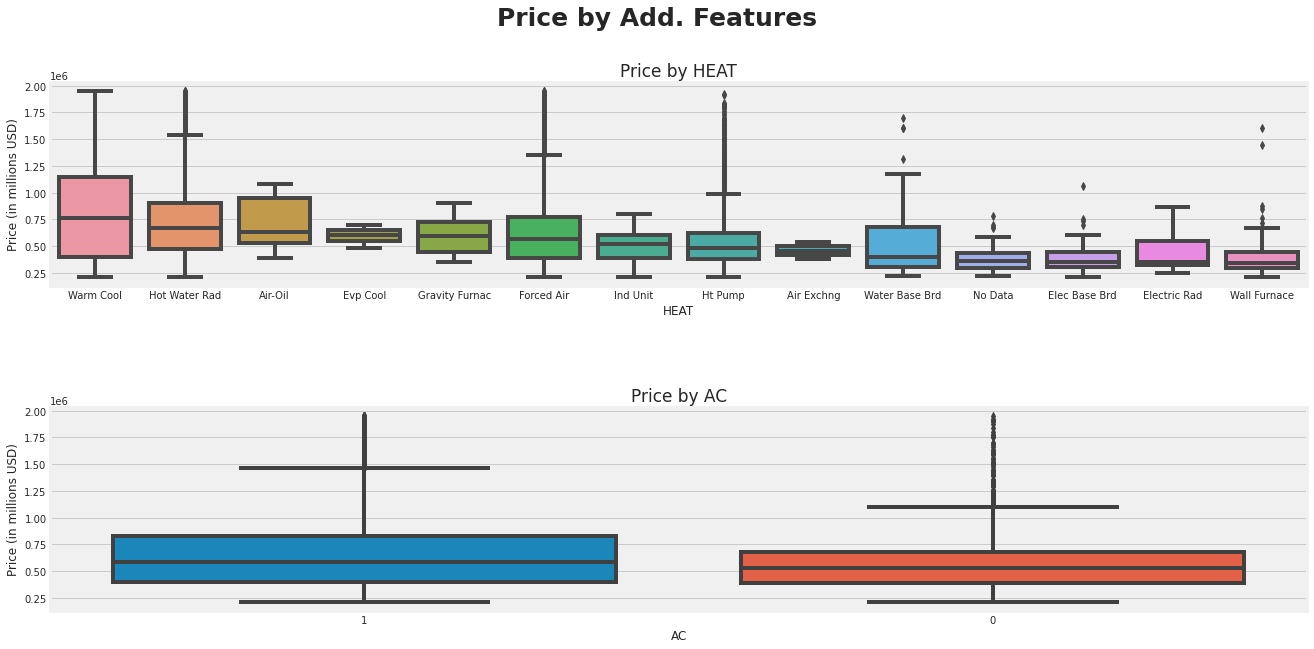

In [62]:
boxplot_cat_price(df=add_feat,features=['HEAT','AC','PRICE'],rows=2,cols=1,fig_size=(20,10),title='Price by Add. Features',pad=7)

In [63]:
for i in ['HEAT','AC']:
  kruskal_price(i,df_q)
  print()

Kruskal-Wallis Test results of HEAT
H Stat = 1423.1735771755878
P = 1.5602105064309593e-296

Kruskal-Wallis Test results of AC
H Stat = 180.4212203336313
P = 6.637886090563339e-40



Since all the P-Value is below the alpha 0.05, we reject H0 which means the population distribution for each features vs price are different. This shows all three features (`Heat` and `AC`) can distinguish price value.

## Grade and Condition

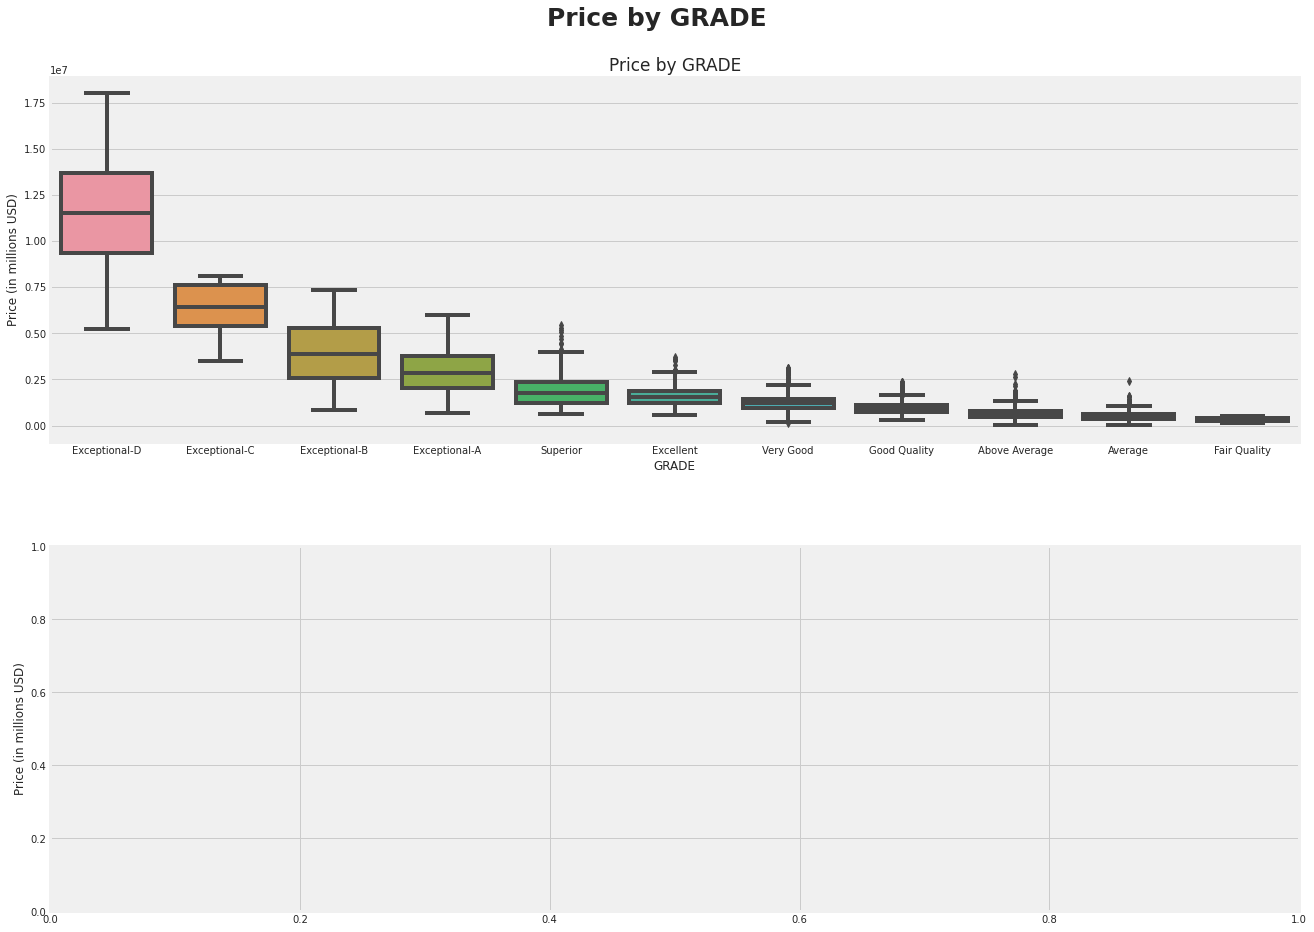

In [64]:
boxplot_cat_price(df=df_t,features=['GRADE','PRICE'],rows=2,cols=1,fig_size=(20,14),title='Price by GRADE',pad=7)

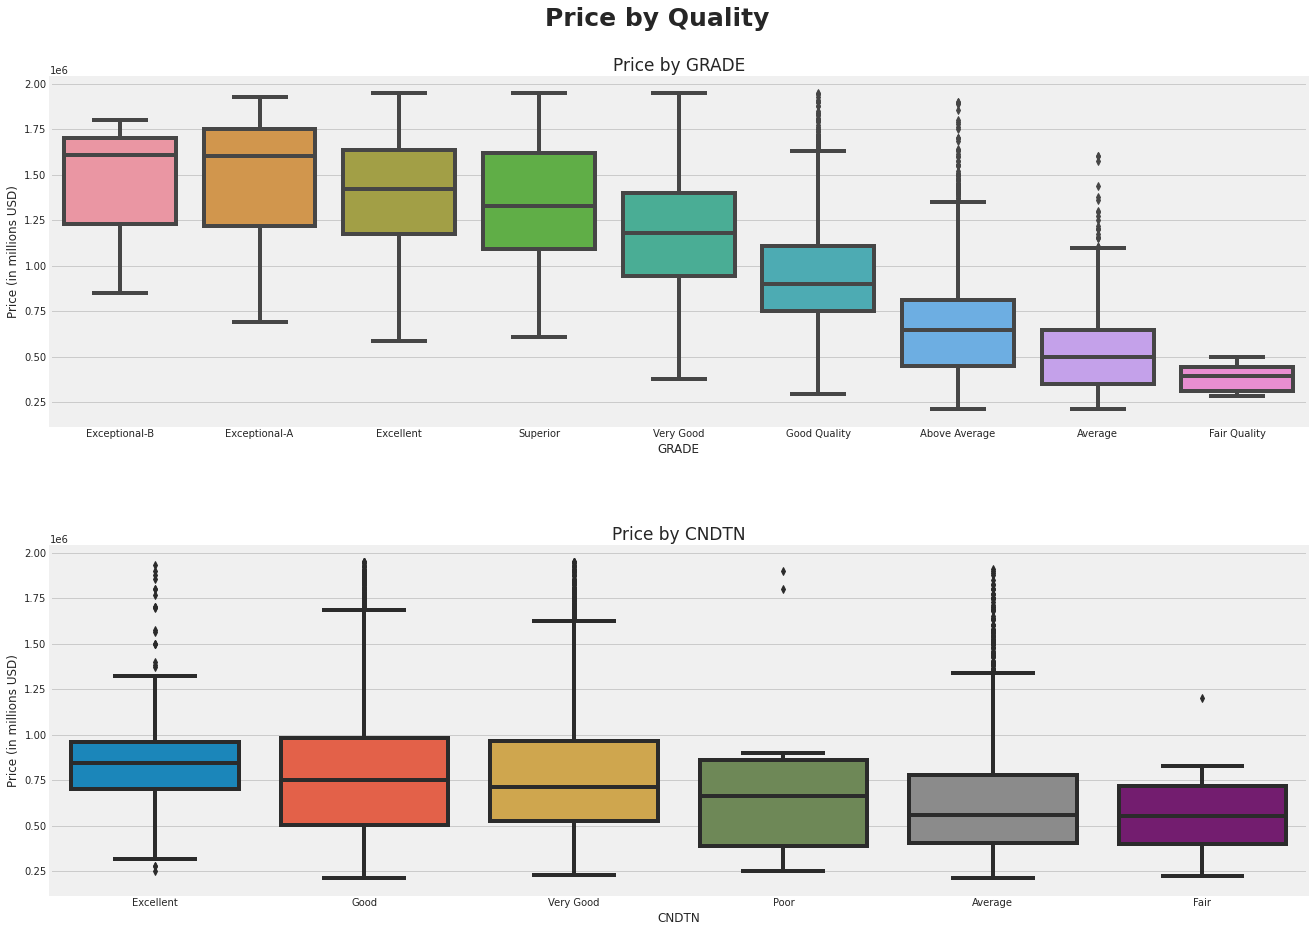

In [65]:
boxplot_cat_price(df=df_viz_95,features=['GRADE','CNDTN','PRICE'],rows=2,cols=1,fig_size=(20,14),title='Price by Quality',pad=7)

In [66]:
for i in ['GRADE','CNDTN']:
  kruskal_price(i,df_q)
  print()

Kruskal-Wallis Test results of GRADE
H Stat = 6052.5594008909275
P = 0.0

Kruskal-Wallis Test results of CNDTN
H Stat = 760.7142270228323
P = 3.642228145658406e-162



Since all the P-Value is below the alpha 0.05, we reject H0 which means the population distribution for each features vs price are different. This shows both features (`GRADE` and `CNDTN`) can distinguish price value.

## Material and Structure

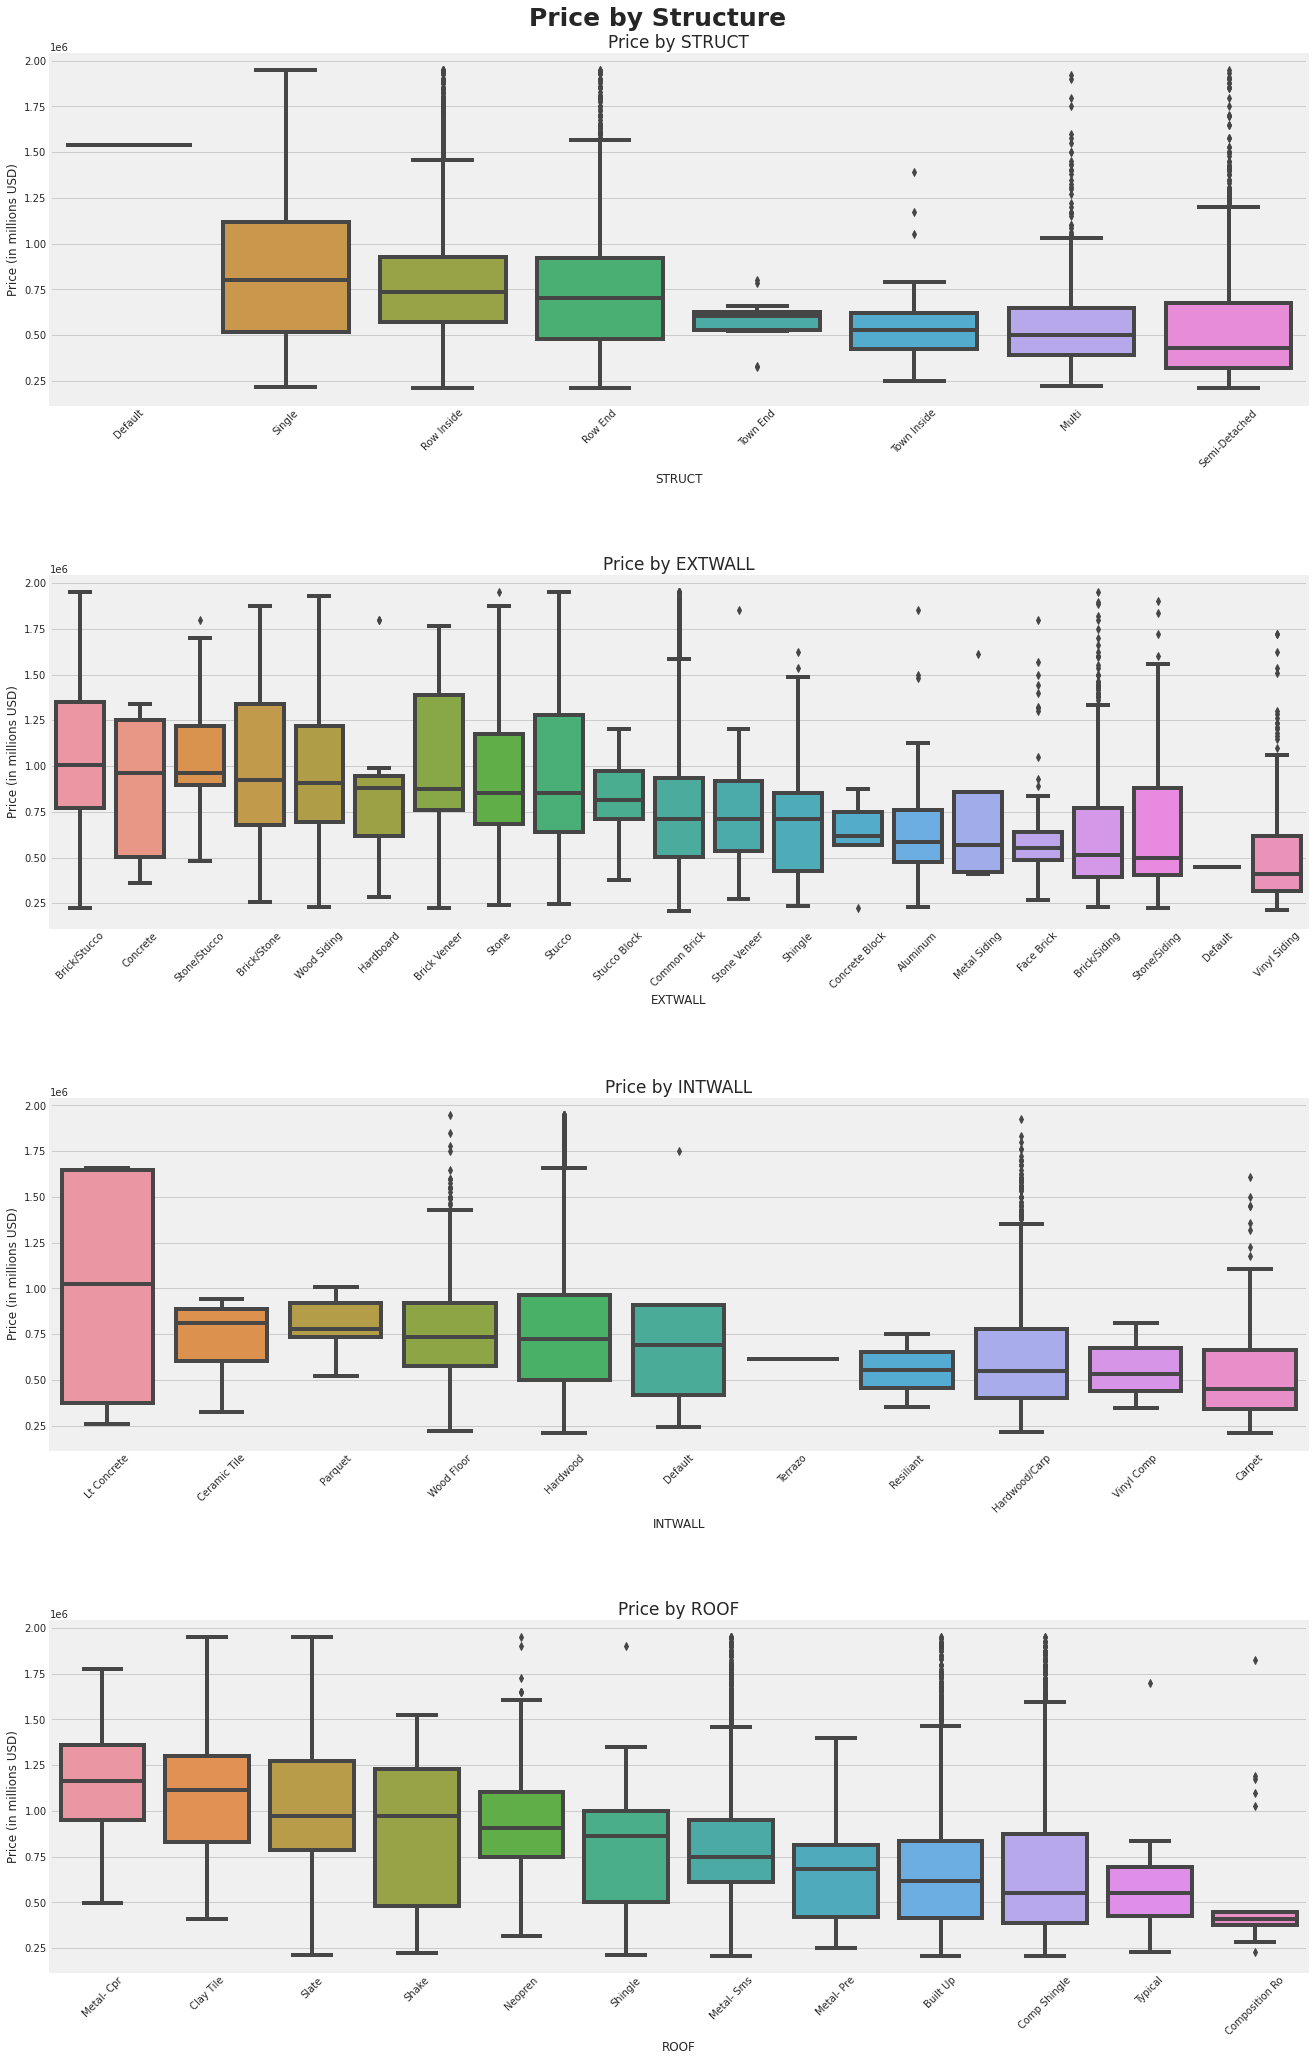

In [67]:
boxplot_cat_price(df=df_viz_95,features=['STRUCT','EXTWALL','INTWALL','ROOF','PRICE'],
                  rows=4,cols=1,fig_size=(20,30),title='Price by Structure',pad=7,rotation=45)

In [68]:
for i in ['STRUCT','EXTWALL','INTWALL','ROOF']:
  kruskal_price(i,df_q)
  print()

Kruskal-Wallis Test results of STRUCT
H Stat = 1248.5967093529468
P = 2.1843065742415515e-265

Kruskal-Wallis Test results of EXTWALL
H Stat = 1027.8183648607212
P = 4.549357596409806e-205

Kruskal-Wallis Test results of INTWALL
H Stat = 388.90496910044806
P = 2.1596390962709416e-77

Kruskal-Wallis Test results of ROOF
H Stat = 1481.5818462431787
P = 3.5548729693404e-310



Since all the P-Value is below the alpha 0.05, we reject H0 which means the population distribution for each features vs price are different. This shows all four features (`Struct`, `Extwall`, `Intwall` and `Roof`) can distinguish price value.

## Other Numerical Features

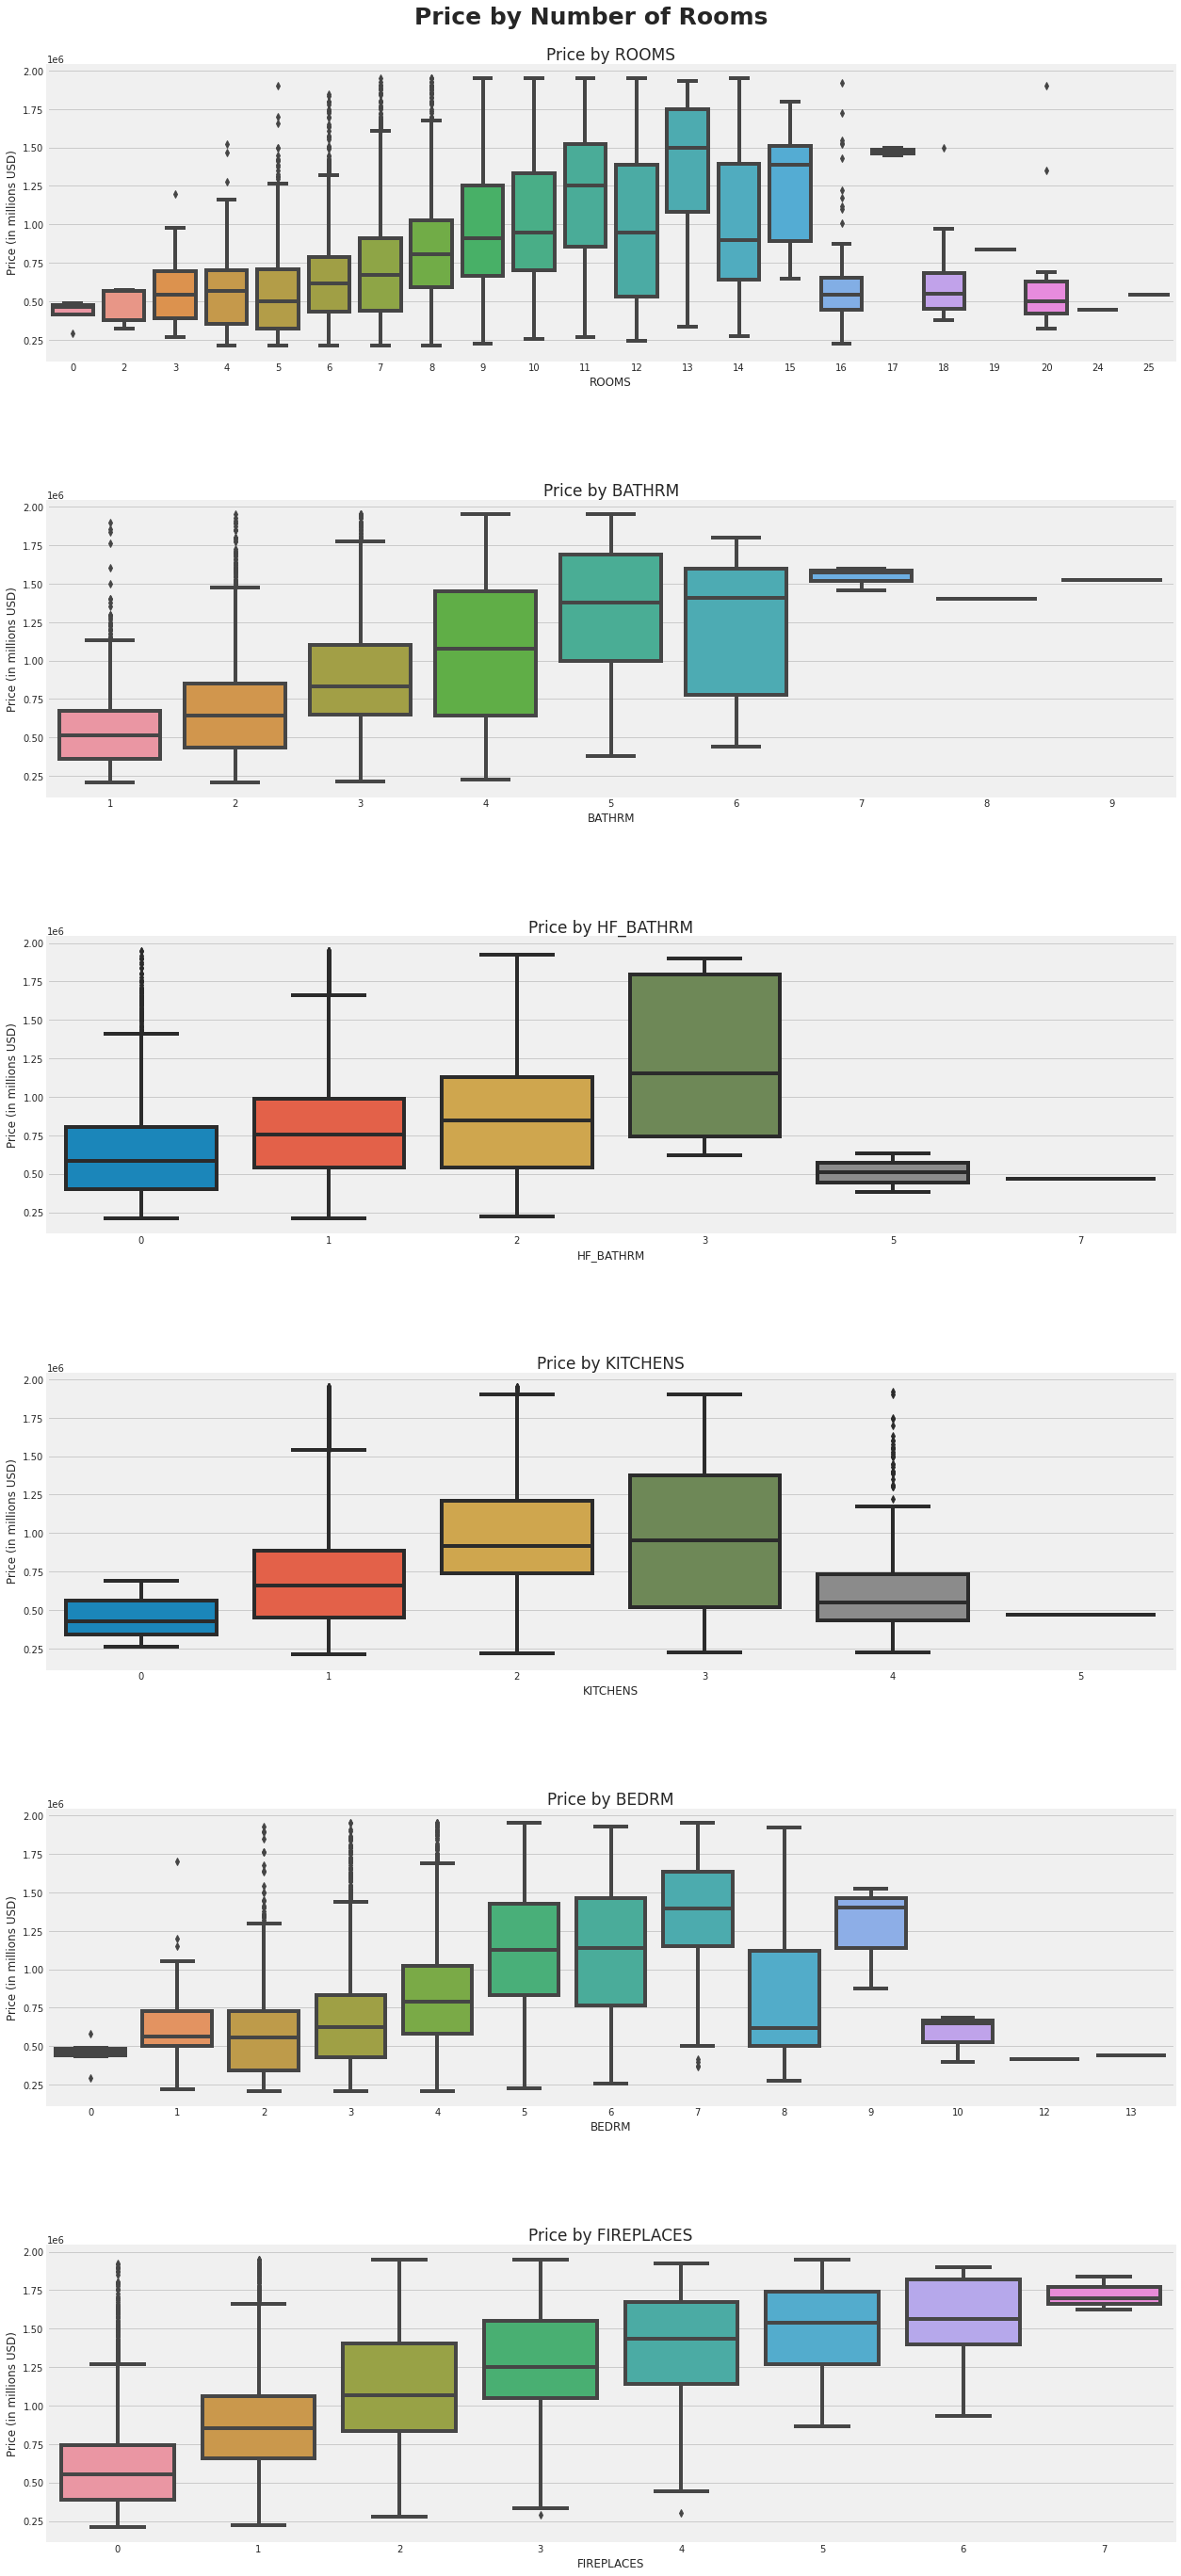

In [69]:
boxplot_cat_price(df=df_viz_95,features=['ROOMS','BATHRM','HF_BATHRM','KITCHENS','BEDRM','FIREPLACES','PRICE'],
                  rows=6,cols=1,fig_size=(20,40),title='Price by Number of Rooms',pad=10,ord=False)

In [70]:
for i in ['ROOMS','BATHRM','HF_BATHRM','KITCHENS','BEDRM','FIREPLACES']:
  kruskal_price(i,df_q)
  print()

Kruskal-Wallis Test results of ROOMS
H Stat = 7362.663856478395
P = 0.0

Kruskal-Wallis Test results of BATHRM
H Stat = 8261.047394743353
P = 0.0

Kruskal-Wallis Test results of HF_BATHRM
H Stat = 3896.4997871739956
P = 0.0

Kruskal-Wallis Test results of KITCHENS
H Stat = 746.8095496097772
P = 3.7046212621438443e-159

Kruskal-Wallis Test results of BEDRM
H Stat = 7612.148268586936
P = 0.0

Kruskal-Wallis Test results of FIREPLACES
H Stat = 5535.309179595148
P = 0.0



Since all the P-Value is below the alpha 0.05, we reject H0 which means the population distribution for each features vs price are different. This shows all features (`Rooms`, `Bathrm`, `HF_Bathrm`, `Kitchens`, `Bedrm`, and `Fireplaces`) can distinguish price value.

Next, we would like to see whether any correlation between these features with price

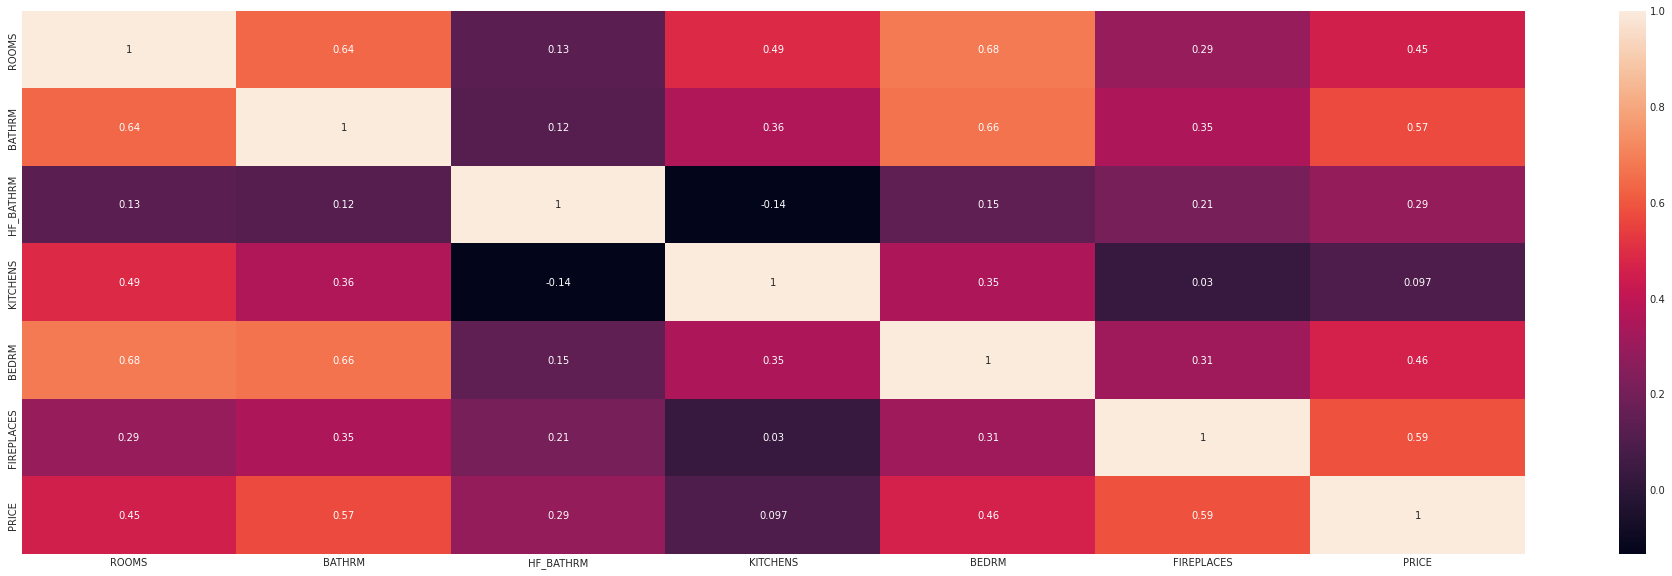

In [71]:
num_feat = df_q[['ROOMS','BATHRM','HF_BATHRM','KITCHENS','BEDRM','FIREPLACES','PRICE']].copy().dropna()

plt.figure(figsize=(30,10))
sns.heatmap(num_feat.corr(), annot=True, cmap='rocket')
plt.show()

## Correlation Network

In order to analyze the correlation between each feature, we will use a correlation network.

In [72]:
%%capture
!pip install network

In [73]:
import networkx as nx

In [74]:
corr = df_q.corr()

In [75]:
indices = corr.index.values
cor_matrix = np.asmatrix(corr)
G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: indices[x])
G.edges(data=True)

EdgeDataView([('index', 'index', {'weight': 1.0}), ('index', 'BATHRM', {'weight': -0.46795503373194813}), ('index', 'HF_BATHRM', {'weight': -0.45795438097640273}), ('index', 'NUM_UNITS', {'weight': -0.028768140992765326}), ('index', 'ROOMS', {'weight': -0.6423379262247513}), ('index', 'BEDRM', {'weight': -0.6374999280334807}), ('index', 'AYB', {'weight': 0.4053267613758962}), ('index', 'YR_RMDL', {'weight': -0.11167822567312764}), ('index', 'EYB', {'weight': -0.147420773801515}), ('index', 'STORIES', {'weight': -0.027343124436420462}), ('index', 'PRICE', {'weight': -0.44357550802569995}), ('index', 'SALE_NUM', {'weight': -0.16557337585406137}), ('index', 'GBA', {'weight': -0.22973238024980547}), ('index', 'BLDG_NUM', {'weight': -0.018479043167960747}), ('index', 'KITCHENS', {'weight': -0.05799629157320082}), ('index', 'FIREPLACES', {'weight': -0.04031264794937925}), ('index', 'LANDAREA', {'weight': -0.4150364481619913}), ('index', 'CMPLX_NUM', {'weight': 0.10898207278754464}), ('index'

In [76]:
def corr_network(G, corr_direction, min_correlation):
    H = G.copy()

    for s1, s2, weight in G.edges(data=True):       
        if corr_direction == "positive":
            if weight["weight"] < 0 or weight["weight"] < min_correlation:
                H.remove_edge(s1, s2)
        else:
            if weight["weight"] >= 0 or weight["weight"] > min_correlation:
                H.remove_edge(s1, s2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    
    weights = tuple([(1+abs(x))**2 for x in weights])
   
    d = dict(nx.degree(H))
    nodelist=d.keys()
    node_sizes=d.values()
    
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(10,10))

    nx.draw_networkx_nodes(H,positions,node_color='#34ebe1',nodelist=nodelist,
                       node_size=tuple([x**3 for x in node_sizes]),alpha=0.8)

    nx.draw_networkx_labels(H, positions, font_size=8)

    if corr_direction == "positive":
        edge_colour = plt.cm.winter 
    else:
        edge_colour = plt.cm.autumn
        
    nx.draw_networkx_edges(H, positions, edgelist=edges,style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 

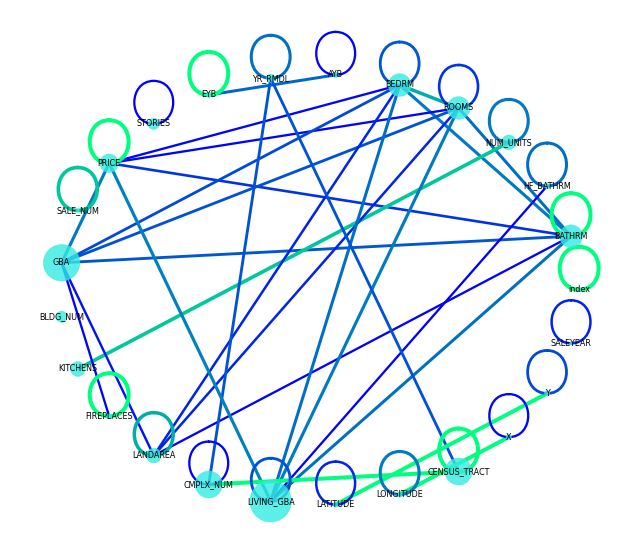

In [77]:
corr_network(G, corr_direction="positive",min_correlation = 0.5)

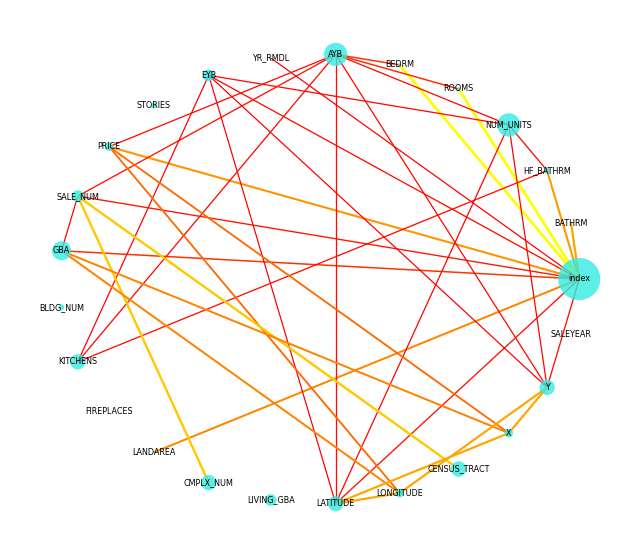

In [78]:
corr_network(G, corr_direction="negative",min_correlation = -0.1)